In [40]:
import numpy as np
import pandas as pd
import sklearn.utils

import matplotlib.pylab as plt
from wordcloud import WordCloud
from tqdm import tqdm_notebook as tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.models import CoherenceModel

np.random.seed(101)
rand_seed = 101

C:\Users\matt\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
%%time
ROOT = "./csv"
df = pd.read_csv(
    ROOT + "/propertweets.csv", 
    encoding='utf-8',
    nrows = 10000,
    low_memory=False, 
    parse_dates=False
)

Wall time: 78.1 ms


In [3]:
del df['Unnamed: 0']
print(df.shape)
print(df.dtypes)
print(df.head())

(10000, 18)
user_id                   int64
user_key                 object
created_at                int64
created_str              object
retweet_count             int64
retweeted                  bool
favorite_count            int64
text                     object
tweet_id                  int64
source                   object
hashtags                 object
expanded_urls            object
mentions                 object
retweeted_status_id       int64
in_reply_to_status_id     int64
tokens                   object
stems                    object
lemmas                   object
dtype: object
              user_id         user_key     created_at  \
0  961701459900342272  Jeannie22757716  1518122470246   
1  961701477164105728        _p_body__  1518122474362   
2  961701487507312641   6728FixerUpper  1518122476828   
3  961701511289073665        LenAulett  1518122482498   
4  961701912880988161       Dsquared69  1518122578245   

                      created_str  retweet_count  retwe

### Feature Engineering


In [4]:
def lexical_diversity(text):
    if len(text) == 0:
        diversity = 0
    else: 
        diversity = float(len(set(text))) / len(text)
    return diversity

In [5]:
df['lemma_diversity'] = df['lemmas'].apply(lexical_diversity)
df['stem_diversity'] = df['stems'].apply(lexical_diversity)

print(df.tail())

                 user_id     user_key     created_at  \
9995  961746261647986688  ireckonmate  1518133151815   
9996  961746261287239680         Em0d  1518133151729   
9997  961746262314938375        drdej  1518133151974   
9998  961746262474350592   barkmartin  1518133152012   
9999  961746262163849216      idas966  1518133151938   

                         created_str  retweet_count  retweeted  \
9995  Thu Feb 08 23:39:11 +0000 2018              0      False   
9996  Thu Feb 08 23:39:11 +0000 2018              0      False   
9997  Thu Feb 08 23:39:11 +0000 2018              0      False   
9998  Thu Feb 08 23:39:12 +0000 2018              0      False   
9999  Thu Feb 08 23:39:11 +0000 2018              0      False   

      favorite_count                                               text  \
9995               0  b'Things the fake news media won\xe2\x80\x99t ...   
9996               0  b'RT @perlmutations: MasterCard: priceless! ht...   
9997               0  b'.@JesseBWatters: 

## tf-idf: term frequency-inverse document frequency

In [6]:
%%time
# select first 5,000,000 items
subset = df.iloc[:5000000]

# tokens = list(df['tokens'].map(lambda word: ' '.join(word)))
# lemmas = list(df['lemmas'].map(lambda word: ' '.join(word)))
# stems = list(df['stems'].map(lambda word: ' '.join(word)))

# print(tokens)
# print(lemmas)
# print(stems)

Wall time: 0 ns


In [7]:
%%time
vectorizer = TfidfVectorizer(
    min_df=5,
    analyzer='word', 
    ngram_range=(1, 2), 
    stop_words='english'
)

vecz = vectorizer.fit_transform(list(df['tokens']))

print(vecz.shape)


(10000, 7363)
Wall time: 297 ms


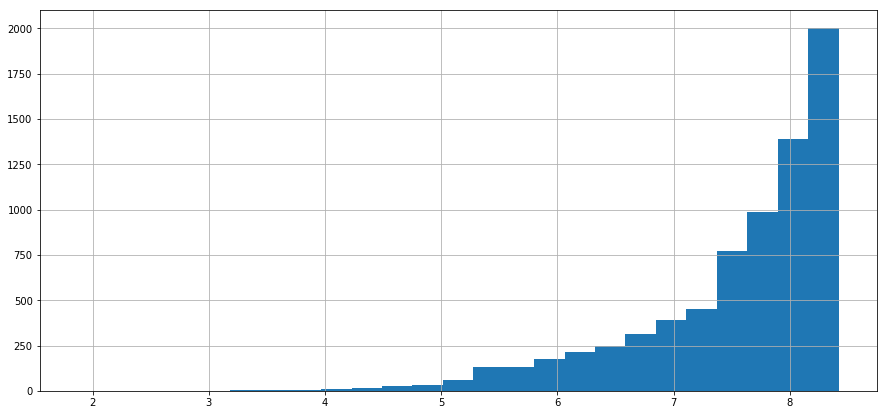

In [8]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']
tfidf.tfidf.hist(bins=25, figsize=(15,7))

In [9]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

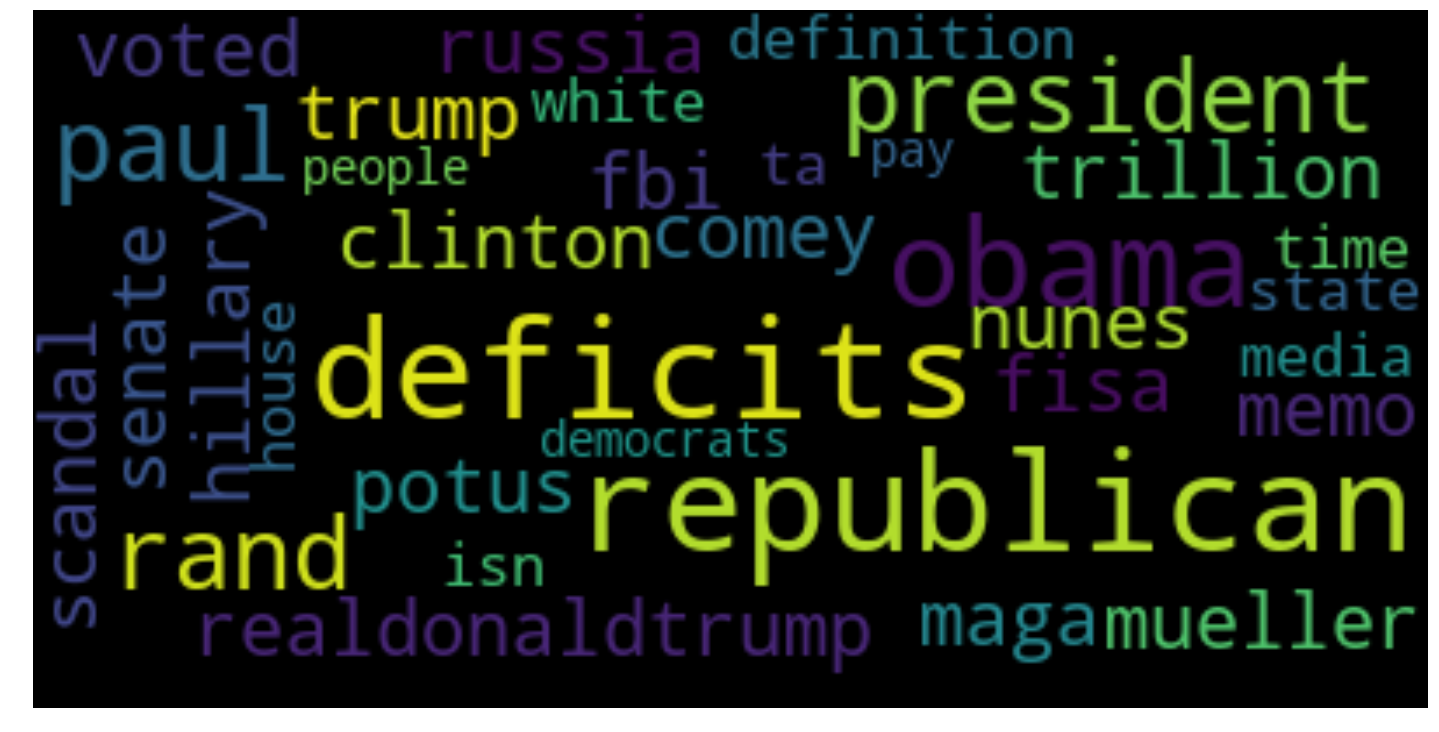

In [10]:
# 30 tokens with lowest tfidf scores (most common)
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(40))

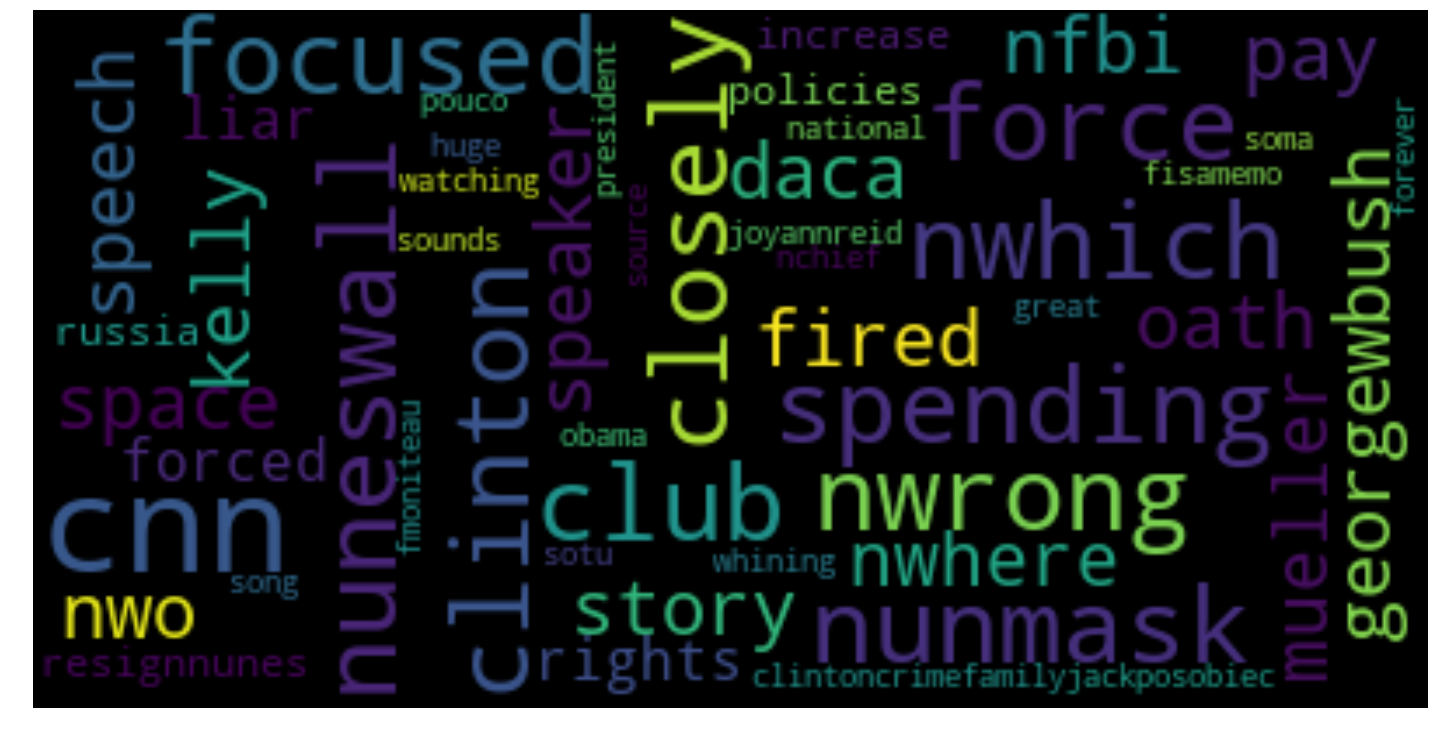

In [11]:
# 30 tokens with highest tfidf scores (least common)
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(40))

In [12]:
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vecz)

svd_tfidf.shape

(10000, 50)

In [14]:
run = False
if run:
# run this (takes times)
    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    print(tsne_tfidf.shape)
    tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
    tsne_tfidf_df.columns = ['x', 'y']
    tsne_tfidf_df['tokens'] = df['tokens']
    tsne_tfidf_df.to_csv('./csv/tsne_tfidf.csv', encoding='utf-8', index=False)
else:
# or import the dataset directly
    tsne_tfidf_df = pd.read_csv('./csv/tsne_tfidf.csv')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.031s...
[t-SNE] Computed neighbors for 10000 samples in 4.844s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.335228
[t-SNE] Error after 500 iterations: 0.891666
(10000, 2)


## Kmeans Clustering

In [24]:
distorsions = []
sil_scores = []
k_max = 80
for k in tqdm(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(
        n_clusters=k, 
        init='k-means++', 
        n_init=1, 
        random_state=42,  
        init_size=1000, 
        verbose=True, 
        max_iter=1000
    )
    kmeans_model.fit(vecz)
    sil_score = silhouette_score(vecz, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distorsions.append(kmeans_model.inertia_)

HBox(children=(IntProgress(value=0, max=78), HTML(value='')))

Init 1/1 with method: k-means++
Inertia for init 1/1: 952.925886
Minibatch iteration 1/100000: mean batch inertia: 0.916881, ewa inertia: 0.916881 
Minibatch iteration 2/100000: mean batch inertia: 0.932010, ewa inertia: 0.917183 
Minibatch iteration 3/100000: mean batch inertia: 0.978970, ewa inertia: 0.918419 
Minibatch iteration 4/100000: mean batch inertia: 0.964576, ewa inertia: 0.919342 
Minibatch iteration 5/100000: mean batch inertia: 0.968625, ewa inertia: 0.920328 
Minibatch iteration 6/100000: mean batch inertia: 0.977945, ewa inertia: 0.921480 
Minibatch iteration 7/100000: mean batch inertia: 0.972190, ewa inertia: 0.922494 
Minibatch iteration 8/100000: mean batch inertia: 0.972798, ewa inertia: 0.923500 
Minibatch iteration 9/100000: mean batch inertia: 0.952152, ewa inertia: 0.924073 
Minibatch iteration 10/100000: mean batch inertia: 0.942418, ewa inertia: 0.924440 
Minibatch iteration 11/100000: mean batch inertia: 0.982590, ewa inertia: 0.925603 
Converged (lack of i

Minibatch iteration 10/100000: mean batch inertia: 0.900277, ewa inertia: 0.813227 
Minibatch iteration 11/100000: mean batch inertia: 0.923311, ewa inertia: 0.815428 
Converged (lack of improvement in inertia) at iteration 11/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 870.800840
Minibatch iteration 1/100000: mean batch inertia: 0.785683, ewa inertia: 0.785683 
Minibatch iteration 2/100000: mean batch inertia: 0.906807, ewa inertia: 0.788105 
Minibatch iteration 3/100000: mean batch inertia: 0.931215, ewa inertia: 0.790967 
Minibatch iteration 4/100000: mean batch inertia: 0.911038, ewa inertia: 0.793368 
Minibatch iteration 5/100000: mean batch inertia: 0.938719, ewa inertia: 0.796275 
Minibatch iteration 6/100000: mean batch inertia: 0.923977, ewa inertia: 0.798829 
Minibatch iteration 7/100000: mean batch inertia: 0.847614, ewa inertia: 0.799804 
Minibatch iteration 8/100000: mean batch inertia: 0.873808, ewa inertia: 0.

Minibatch iteration 11/100000: mean batch inertia: 0.901718, ewa inertia: 0.820699 
Minibatch iteration 12/100000: mean batch inertia: 0.859885, ewa inertia: 0.821482 
Converged (lack of improvement in inertia) at iteration 12/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 791.408175
Minibatch iteration 1/100000: mean batch inertia: 0.808438, ewa inertia: 0.808438 
Minibatch iteration 2/100000: mean batch inertia: 0.770366, ewa inertia: 0.807677 
Minibatch iteration 3/100000: mean batch inertia: 0.842009, ewa inertia: 0.808363 
Minibatch iteration 4/100000: mean batch inertia: 0.758838, ewa inertia: 0.807373 
Minibatch iteration 5/100000: mean batch inertia: 0.886594, ewa inertia: 0.808957 
Minibatch iteration 6/100000: mean batch inertia: 0.760879, ewa inertia: 0.807996 
Minibatch iteration 7/100000: mean batch inertia: 0.794820, ewa inertia: 0.807732 
Minibatch iteration 8/100000: mean batch inertia: 0.815271, ewa inertia: 0.

Minibatch iteration 6/100000: mean batch inertia: 0.794360, ewa inertia: 0.713796 
Minibatch iteration 7/100000: mean batch inertia: 0.726550, ewa inertia: 0.714051 
Minibatch iteration 8/100000: mean batch inertia: 0.810849, ewa inertia: 0.715987 
Minibatch iteration 9/100000: mean batch inertia: 0.770744, ewa inertia: 0.717082 
[MiniBatchKMeans] Reassigning 33 cluster centers.
Minibatch iteration 10/100000: mean batch inertia: 0.748403, ewa inertia: 0.717708 
Minibatch iteration 11/100000: mean batch inertia: 0.883583, ewa inertia: 0.721025 
Converged (lack of improvement in inertia) at iteration 11/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 744.090239
Minibatch iteration 1/100000: mean batch inertia: 0.705431, ewa inertia: 0.705431 
Minibatch iteration 2/100000: mean batch inertia: 0.795054, ewa inertia: 0.707223 
Minibatch iteration 3/100000: mean batch inertia: 0.757942, ewa inertia: 0.708238 
Minibatch iteration 4/100

Converged (lack of improvement in inertia) at iteration 35/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 717.186623
Minibatch iteration 1/100000: mean batch inertia: 0.794181, ewa inertia: 0.794181 
Minibatch iteration 2/100000: mean batch inertia: 0.706690, ewa inertia: 0.792431 
Minibatch iteration 3/100000: mean batch inertia: 0.782508, ewa inertia: 0.792233 
Minibatch iteration 4/100000: mean batch inertia: 0.782905, ewa inertia: 0.792046 
Minibatch iteration 5/100000: mean batch inertia: 0.735971, ewa inertia: 0.790925 
Minibatch iteration 6/100000: mean batch inertia: 0.706077, ewa inertia: 0.789228 
Minibatch iteration 7/100000: mean batch inertia: 0.765277, ewa inertia: 0.788749 
Minibatch iteration 8/100000: mean batch inertia: 0.755477, ewa inertia: 0.788084 
Minibatch iteration 9/100000: mean batch inertia: 0.737426, ewa inertia: 0.787071 
[MiniBatchKMeans] Reassigning 42 cluster centers.
Minibatch iteration 10/1000

Converged (lack of improvement in inertia) at iteration 20/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 675.667390
Minibatch iteration 1/100000: mean batch inertia: 0.767404, ewa inertia: 0.767404 
Minibatch iteration 2/100000: mean batch inertia: 0.756048, ewa inertia: 0.767177 
Minibatch iteration 3/100000: mean batch inertia: 0.719936, ewa inertia: 0.766232 
Minibatch iteration 4/100000: mean batch inertia: 0.676417, ewa inertia: 0.764436 
Minibatch iteration 5/100000: mean batch inertia: 0.665130, ewa inertia: 0.762450 
Minibatch iteration 6/100000: mean batch inertia: 0.747749, ewa inertia: 0.762156 
Minibatch iteration 7/100000: mean batch inertia: 0.681106, ewa inertia: 0.760535 
Minibatch iteration 8/100000: mean batch inertia: 0.718603, ewa inertia: 0.759696 
Minibatch iteration 9/100000: mean batch inertia: 0.631270, ewa inertia: 0.757128 
[MiniBatchKMeans] Reassigning 47 cluster centers.
Minibatch iteration 10/1000

Minibatch iteration 8/100000: mean batch inertia: 0.652261, ewa inertia: 0.749151 
Minibatch iteration 9/100000: mean batch inertia: 0.668194, ewa inertia: 0.747532 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/100000: mean batch inertia: 0.751879, ewa inertia: 0.747619 
Minibatch iteration 11/100000: mean batch inertia: 0.842503, ewa inertia: 0.749516 
Minibatch iteration 12/100000: mean batch inertia: 0.701943, ewa inertia: 0.748565 
Minibatch iteration 13/100000: mean batch inertia: 0.766858, ewa inertia: 0.748931 
Minibatch iteration 14/100000: mean batch inertia: 0.767278, ewa inertia: 0.749298 
Minibatch iteration 15/100000: mean batch inertia: 0.706113, ewa inertia: 0.748434 
Minibatch iteration 16/100000: mean batch inertia: 0.743559, ewa inertia: 0.748337 
Minibatch iteration 17/100000: mean batch inertia: 0.698117, ewa inertia: 0.747332 
Minibatch iteration 18/100000: mean batch inertia: 0.696043, ewa inertia: 0.746307 
Minibatch iteration 19/10000

Minibatch iteration 24/100000: mean batch inertia: 0.743815, ewa inertia: 0.739309 
Minibatch iteration 25/100000: mean batch inertia: 0.718736, ewa inertia: 0.738897 
Minibatch iteration 26/100000: mean batch inertia: 0.696830, ewa inertia: 0.738056 
Minibatch iteration 27/100000: mean batch inertia: 0.791338, ewa inertia: 0.739122 
Minibatch iteration 28/100000: mean batch inertia: 0.748756, ewa inertia: 0.739314 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 29/100000: mean batch inertia: 0.766102, ewa inertia: 0.739850 
Minibatch iteration 30/100000: mean batch inertia: 0.743042, ewa inertia: 0.739914 
Minibatch iteration 31/100000: mean batch inertia: 0.819936, ewa inertia: 0.741514 
Converged (lack of improvement in inertia) at iteration 31/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 653.882262
Minibatch iteration 1/100000: mean batch inertia: 0.745573, ewa inertia: 0.745573 
Minibatch iteration

Minibatch iteration 17/100000: mean batch inertia: 0.712987, ewa inertia: 0.722327 
Minibatch iteration 18/100000: mean batch inertia: 0.736311, ewa inertia: 0.722606 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 19/100000: mean batch inertia: 0.750633, ewa inertia: 0.723167 
Minibatch iteration 20/100000: mean batch inertia: 0.661099, ewa inertia: 0.721925 
Minibatch iteration 21/100000: mean batch inertia: 0.666348, ewa inertia: 0.720814 
Minibatch iteration 22/100000: mean batch inertia: 0.731831, ewa inertia: 0.721034 
Minibatch iteration 23/100000: mean batch inertia: 0.765948, ewa inertia: 0.721933 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 24/100000: mean batch inertia: 0.727055, ewa inertia: 0.722035 
Minibatch iteration 25/100000: mean batch inertia: 0.802292, ewa inertia: 0.723640 
Minibatch iteration 26/100000: mean batch inertia: 0.702488, ewa inertia: 0.723217 
Minibatch iteration 27/100000: mean batch inertia: 0.740044,

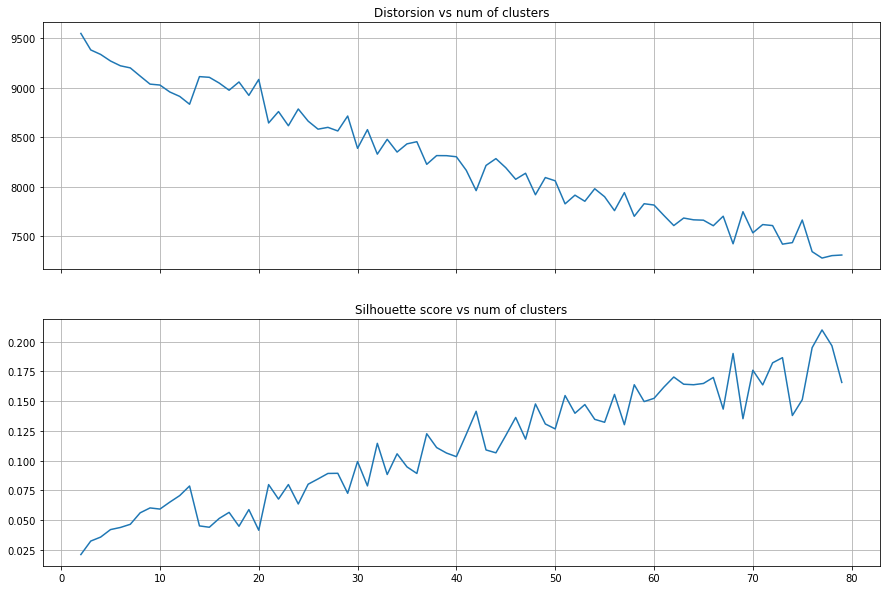

In [25]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters')
ax2.grid(True)

In [26]:
num_clusters = 50
kmeans_model = MiniBatchKMeans(
    n_clusters=num_clusters, 
    init='k-means++', 
    n_init=1, 
    random_state=42,                       
    init_size=1000, 
    batch_size=1000, 
    verbose=True, 
    max_iter=1000, 
)
kmeans = kmeans_model.fit(vecz)
kmeans_clusters = kmeans.predict(vecz)
kmeans_distances = kmeans.transform(vecz)

Init 1/1 with method: k-means++
Inertia for init 1/1: 726.622757
Minibatch iteration 1/10000: mean batch inertia: 0.754963, ewa inertia: 0.754963 
Minibatch iteration 2/10000: mean batch inertia: 0.729424, ewa inertia: 0.749856 
Minibatch iteration 3/10000: mean batch inertia: 0.727729, ewa inertia: 0.745431 
Minibatch iteration 4/10000: mean batch inertia: 0.738135, ewa inertia: 0.743972 
Minibatch iteration 5/10000: mean batch inertia: 0.734652, ewa inertia: 0.742108 
Minibatch iteration 6/10000: mean batch inertia: 0.735949, ewa inertia: 0.740876 
Minibatch iteration 7/10000: mean batch inertia: 0.714557, ewa inertia: 0.735613 
Minibatch iteration 8/10000: mean batch inertia: 0.742827, ewa inertia: 0.737056 
Minibatch iteration 9/10000: mean batch inertia: 0.711976, ewa inertia: 0.732040 
Minibatch iteration 10/10000: mean batch inertia: 0.721011, ewa inertia: 0.729834 
[MiniBatchKMeans] Reassigning 39 cluster centers.
Minibatch iteration 11/10000: mean batch inertia: 0.710194, ewa 

In [27]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)], 
                           columns=['keyword_{0}'.format(i) for i in range(10)],
                           data=all_keywords)
keywords_df

keyword_0                             keyword_1  \
topic_0             paul suddenly                           reality pay   
topic_1               state cover                        requests comey   
topic_2                   eplodes  ta cuaaaaaarrgggghghghghghghhghhghhg   
topic_3                  deficits                          deficits isn   
topic_4       president tomfitton                        tomfitton deep   
topic_5                    acting                                  coup   
topic_6                obama damn                              nwhy don   
topic_7                     obama                                  maga   
topic_8                 obamagate                                  fisa   
topic_9             fbi documents                                moking   
topic_10                 deficits                   deficits republican   
topic_11                memo turn                       obama watergate   
topic_12                   terror                            case purge   
topic_13                    msnbc                                  didn   
topic_14          dollar deficits                                  hand   
topic_15            youtube video                               youtube   
topic_16         russians uranium                  administration allow   
topic_17                  protect                                 media   
topic_18                 loudobbs                                 trash   
topic_19              incompetent                               destroy   
topic_20             head eplodes                               eplodes   
topic_21                  mueller                             committee   
topic_22              obama going                        realjameswoods   
topic_23                     paid                       obama assuredly   
topic_24          president trump                             president   
topic_25            knowing awful                         happened calm   
topic_26        thoroughly forgot                         neighbor beat   
topic_27             service high                        secret service   
topic_28                committee                    multiple committee   
topic_29                  awesome                                  vets   
topic_30      thomaspaine melania                         house removal   
topic_31          time presidency                  realdonaldtrump time   
topic_32                colluding                           clintoncash   
topic_33                  yelling                          amid scandal   
topic_34              probe obama                           issue obama   
topic_35                     read                                  memo   
topic_36  botching investigations                        anthra attacks   
topic_37                  telling                                  shut   
topic_38  reneecarrollaz genflynn                        reneecarrollaz   
topic_39                    media                       timed strategic   
topic_40            removal pagan                         pagan demonic   
topic_41                     sept                               meeting   
topic_42      thomaspaine melania                         house removal   
topic_43                socialist                                pretty   
topic_44                   jordan                        strzokpagetets   
topic_45                noh korea                               weapons   
topic_46             politicalsho               politicalsho drainthesw   
topic_47  hillaryclinton colluded               evidence hillaryclinton   
topic_48               mike flynn                                  mike   
topic_49               whiteboard                       maga whiteboard   

                                       keyword_2  \
topic_0                         awakened reality   
topic_1                               cover mode   
topic_2   cuaaaaaarrgggghghghghghghhghhghh

In [30]:
svd = TruncatedSVD(n_components=2, random_state=0)
svd_kmeans = svd.fit_transform(vecz)
run = False
if run:
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_kmeans = tsne_model.fit_transform(svd_kmeans)
    kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
    kmeans_df['cluster'] = kmeans_clusters
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)
    kmeans_df.to_csv('./data/tsne_kmeans.csv', index=False, encoding='utf-8')
else:
    kmeans_df = pd.read_csv('./data/tsne_kmeans.csv')
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)

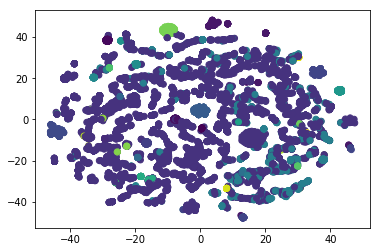

x          y cluster
0 -13.022781  11.930355       7
1  16.526720 -25.254396       7
2  13.238400  10.408913       7
3  40.212482   6.216438       7
4 -13.734802  10.349233       7

In [39]:
plt.scatter(x = kmeans_df.x, y = kmeans_df.y, c = kmeans_df.cluster)
plt.show()
kmeans_df.head()